# Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data and unzip them.

After that, let’s import some necessities.

In [1]:
!wget 'https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/CA_data.zip'
!unzip CA_data.zip -x __MACOSX/*

--2025-04-22 00:53:45--  https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/CA_data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/CA_data.zip [following]
--2025-04-22 00:53:45--  https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/CA_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81802360 (78M) [application/zip]
Saving to: ‘CA_data.zip’

CA_data.zip         100%[===================>]  78.01M  59.3MB/s    in 1.3s    

2025-04-22 00:53:54 (59.3 MB/s) - ‘CA_data.zip’ saved [81802360/81802360]


In [3]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
np.random.seed(1)
random.seed(1)

#The Cornell Movie-Dialogs Corpus

The next move is to reformat our data file and load the data into functional structures.

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [4]:
#Loading the data
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
#lines = open('movie-corpus/utterances.jsonl', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])

limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()

len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [5]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])

    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [6]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])

    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs.
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [7]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):

            pairs_final.append(p)

    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v)

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [8]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [9]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [10]:
# keeping the pairs with words in the vocab
# The code is for your refernce, it take too long (12m) so we provide you the file already processed
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
# pairs_final = trimRareWords(new_vocab, pairs_final)
# with open ('final_pairs_v21.pkl','wb') as f:
#     pairs_final = pickle.dump(pairs_final,f)

with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)

pairs_final_train = pairs_final
len(pairs_final_train)

114938

#Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

To download GloVe embeddings and uzip them use the following commands:

Now let's load them in the embedding layer

In [11]:
!pip install tokenizers

In [12]:
import torch.nn as nn
import torch
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, pre_tokenizers

torch.manual_seed(1)

test = False
GRU_units = 50
batch_size = 512
emb_dim = 50
init_lr = 0.001

pad_token = 'pad0'
vocab_with_pad = [pad_token] + new_vocab
wordtoix = {word: idx for idx, word in enumerate(vocab_with_pad)}
ixtoword = {idx: word for word, idx in wordtoix.items()}
tokenizer = Tokenizer(models.WordLevel(vocab=wordtoix, unk_token='[UNK]'))
# tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
# hf_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer, pad_token=pad_token)

def make_embedding_layer(embedding_dim=50, glove=True, glove_weight_path="glove.6B.50d.txt"):
    """
    Creates a PyTorch nn.Embedding layer with either:
    (1) GloVe pre-trained weights if glove=True, OR
    (2) A zero-initialized matrix if glove=False.
    """

    if not glove:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim), dtype=np.float32)
    else:
        print('Loading glove...')
        embeddings_index = {}
        # Make sure you have 'glove.6B.50d.txt' in the correct path
        # or adjust the path as needed.
        with open(glove_weight_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print("GloVe", embedding_dim, "loaded!")

        # Initialize an empty embedding matrix
        embedding_matrix = np.zeros((vocab_len, embedding_dim), dtype=np.float32)

        # Fill the embedding matrix with GloVe values
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    embedding_layer = nn.Embedding(
        num_embeddings=vocab_len,
        embedding_dim=embedding_dim,
        padding_idx=0
    )

    # Convert the numpy embedding matrix to a PyTorch tensor
    with torch.no_grad():
        embedding_layer.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))

    # If you want the embedding to remain un-trainable, set requires_grad = False:
    embedding_layer.weight.requires_grad = False

    return embedding_layer



In [13]:
# Create the embedding layer
embeddings = make_embedding_layer(embedding_dim=emb_dim)

Loading glove...
GloVe 50 loaded!


#Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



#Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

In [14]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size=batch_size, dropout=0.2):
        """
        Initializes the Encoder.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of the embedding vectors.
            enc_units (int): Number of units in the GRU.
            batch_size (int): Size of each batch.
            embeddings (torch.Tensor, optional): Pre-trained embedding weights. Defaults to None.
            dropout (float, optional): Dropout probability. Defaults to 0.2.
        """
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units

        """
        Task 1: Implementing the encoder

        Begin
        """
        #  pass the embedding into a bidirectional version of the GRU
        self.embeddings = embeddings
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, enc_units, bidirectional=True, batch_first=True)



        """
        End Task 1
        """

    def forward(self, x, hidden=None):
        """
        Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length).
            hidden (torch.Tensor, optional): Initial hidden state. Defaults to None.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Output sequences, forward hidden state, backward hidden state.
        """
        # x: [batch_size, seq_length]
        x = self.embeddings(x)  # [batch_size, seq_length, embedding_dim]
        x = self.dropout(x)

        # Pass through the GRU
        # If hidden is not provided, it defaults to zeros
        output, hidden = self.gru(x, hidden)
        # output: [batch_size, seq_length, enc_units * 2]
        # hidden: [num_layers * num_directions, batch_size, enc_units]

        # Separate the hidden states for forward and backward directions
        # Since it's bidirectional and num_layers=1, hidden has shape (2, batch_size, enc_units)
        hidden_f = hidden[0]  # Forward hidden state: [batch_size, enc_units]
        hidden_b = hidden[1]  # Backward hidden state: [batch_size, enc_units]

        return output, hidden_f, hidden_b

    def initialize_hidden_state(self):
            """
            Initializes the hidden state to zeros.

            Returns:
                torch.Tensor: Initialized hidden state of shape (num_directions, batch_size, enc_units).
            """
            # Number of directions is 2 for bidirectional GRU
            return torch.zeros(2, self.batch_size, self.enc_units)


In [15]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

In [16]:
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(units, units)
        self.W2 = nn.Linear(units, units)
        self.V = nn.Linear(units, 1)
        self.units = units

    def forward(self, query, values):
        """
        Args:
            query: Decoder hidden state at current time step. Shape: (batch_size, hidden_size)
            values: Encoder outputs. Shape: (batch_size, max_length, hidden_size)

        Returns:
            context_vector: Weighted sum of encoder outputs. Shape: (batch_size, hidden_size)
            attention_weights: Attention scores. Shape: (batch_size, max_length, 1)
        """
        # Add a time axis to the query to enable broadcasting
        # Shape: (batch_size, 1, hidden_size)
        query_with_time_axis = query.unsqueeze(1)

        # Calculate the score
        # Shape before self.V: (batch_size, max_length, units)
        score = self.V(torch.tanh(
            self.W1(query_with_time_axis) + self.W2(values)
        ))

        # Apply softmax to get attention weights
        # Shape: (batch_size, max_length, 1)
        attention_weights = F.softmax(score, dim=1)

        # Compute the context vector as the weighted sum of encoder outputs
        # Shape after sum: (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [17]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size=batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.embedding = embeddings
        self.units = 2 * dec_units  # Assuming bidirectional encoder
        self.fc = nn.Linear(self.units, vocab_len)

        """
        Task 2: Implementing the decoder with attention

        Begin
        """
        self.attention = BahdanauAttention(self.units)
        self.embedding_dropout = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.2)
        self.decoder_gru_l1 = nn.GRU(embedding_dim + self.units, self.units, batch_first=True)
        self.decoder_gru_l2 = nn.GRU(self.units, self.units, batch_first=True)


        """
        End Task 2
        """


    def forward(self, x, hidden, enc_output):
        """
        Args:
            x: Input token indices. Shape: (batch_size, 1)
            hidden: Previous hidden state. Shape: (batch_size, hidden_size)
            enc_output: Encoder outputs. Shape: (batch_size, max_length, hidden_size)

        Returns:
            output: Predictions for the next token. Shape: (batch_size, vocab_len)
            state: Current hidden state. Shape: (batch_size, hidden_size)
            attention_weights: Attention scores. Shape: (batch_size, max_length, 1)
        """
        # Compute attention weights and context vector
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Embed the input token
        # Shape: (batch_size, 1, embedding_dim)
        x = self.embedding_dropout(self.embedding(x))

        # Concatenate context vector and embedded input
        # Shape: (batch_size, 1, embedding_dim + hidden_size)
        x = torch.cat([context_vector.unsqueeze(1), x], dim=-1)

        # Pass through the first GRU layer
        # GRU expects input of shape (batch_size, seq_length, input_size)
        # Output shape: (batch_size, 1, units)
        x, _ = self.decoder_gru_l1(x)

        # Apply dropout
        x = self.dropout(x)

        # Pass through the second GRU layer
        # Output shape: (batch_size, 1, units)
        x, state = self.decoder_gru_l2(x)

        # Reshape to (batch_size, units)
        x = x.squeeze(1)

        # Pass through the fully connected layer
        # Shape: (batch_size, vocab_len)
        x = self.fc(x)


        return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_len, 50, GRU_units)


#Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [19]:
import unicodedata
import matplotlib.ticker as ticker

def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) for seq in sequences]

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence, device):
    encoder.to(device)
    decoder.to(device)

    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q)

    inputs = torch.Tensor(inputs).to(torch.int32).to(device)

    result = ''

    hidden = torch.zeros(2, inputs.shape[0], GRU_units)
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = torch.cat((enc_hidden_f, enc_hidden_b), dim=-1)  # Shape: (1, batch, hidden_size * 2)
    dec_input = torch.tensor([[wordtoix[start_token]]], device=device)  # Shape: (1, 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        dec_hidden = dec_hidden[0]
        attention_weights = attention_weights.squeeze(0).view(-1).detach().cpu().numpy()

        attention_plot[t] = attention_weights
        predicted_id =  predictions.argmax(dim=1).item()

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot

        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = torch.tensor([[predicted_id]], device=device)

    return result, sentence, attention_plot

def answer(sentence, training=False, device="cpu"):
    result, sentence, attention_plot = evaluate(sentence,device)

    if training:
        return result

    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

#Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties.

In [20]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token, device="cpu"):


    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q)

    inputs = torch.Tensor(inputs).to(torch.int32).to(device)

    hidden = torch.zeros(2, inputs.shape[0], GRU_units)
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)   # (1, max_len_q, 2*enc_hidden_dim), (1, enc_hidden_dim), (1, enc_hidden_dim)

    # Concatenate forward and backward hidden states for the decoder
    dec_hidden = torch.cat((enc_hidden_f, enc_hidden_b), dim=-1)  # shape (1, batch_size, 2*GRU_units)
    dec_input = torch.tensor([[wordtoix[start_token]]], device=device)


    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        dec_hidden = dec_hidden[0]

        predictions = F.softmax(predictions,-1)
        probs = predictions[0].detach().numpy()

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]

        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores

    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores

    final_result =[]

    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))

    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

#Training procedure

#Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [21]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

#Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference.



In [22]:
import torch.optim as optim
encoder_optimizer = optim.Adam(encoder.parameters(), lr=init_lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=init_lr)

def train_step(
    inp,
    targ,
    enc_hidden,
    device
):
    """
    Equivalent PyTorch/HuggingFace-style training step for a seq2seq model
    with teacher forcing.
    """
    inp = inp.to(device)
    targ = targ.to(device)
    enc_hidden = enc_hidden.to(device)
    # Ensure we're in training mode
    encoder.train()
    decoder.train()
    encoder.to(device)
    decoder.to(device)

    # Clear the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0.0

    # Forward pass through the encoder
    # (Returns enc_output, enc_hidden_f, enc_hidden_b, similar to your TF code)
    enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)

    # Concatenate the forward and backward encoder hidden states
    # (mimicking `Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])` in Keras)
    dec_hidden = torch.cat([enc_hidden_f, enc_hidden_b], dim=-1)

    # Initialize the decoder input with the start token (teacher forcing setup)
    batch_size = inp.size(0)
    device = inp.device
    dec_input = torch.tensor(
        [wordtoix[start_token]] * batch_size,
        dtype=torch.long,
        device=device
    ).unsqueeze(1)  # shape: (batch_size, 1)

    # Teacher forcing: feed the *target* back into the decoder at each step
    for t in range(1, targ.size(1)):
        # Forward pass through the decoder
        # returns (predictions, dec_hidden, <optional other outputs>)
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = dec_hidden[0]
        # Accumulate the loss at each time step
        # predictions shape example: (batch_size, vocab_size)
        # targ[:, t] shape: (batch_size,)
        step_loss = loss_fn(predictions, targ[:, t])
        loss += step_loss

        # The target word at timestep t becomes the input for the next step
        dec_input = targ[:, t].unsqueeze(1)

    # Compute average loss per sequence length
    batch_loss = loss / targ.size(1)

    if not torch.isnan(batch_loss):
      # Backpropagation
      batch_loss.backward()

      torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.0)
      torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)



      # Update parameters
      encoder_optimizer.step()
      decoder_optimizer.step()

    return batch_loss.item()

In [23]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 100
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [24]:
def test_bot(k = 5, beam = False, device="cpu"):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k,device=device))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')

    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('#'*20)

#Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 1 Batch 37 Loss: 5.3955
Epoch 1 Batch 74 Loss: 5.3033
Epoch 1 Batch 111 Loss: 4.9903
Epoch 1 Batch 148 Loss: 4.8985
Epoch 1 Batch 185 Loss: 5.0624
Epoch 1 Batch 222 Loss: 4.9701

*** Epoch 1 Loss 5.4450 ***

####################
Greedy| Q: Hello   A: 
Beam  5 |  Hello   A: you 
%
Greedy| Q: How are you ?  A: 
Beam  5 |  How are you ?  A: 
%
Greedy| Q: What are you doing ?  A: 
Beam  5 |  What are you doing ?  A: 
%
Greedy| Q: What is your favorite restaurant ?  A: 
Beam  5 |  What is your favorite restaurant ?  A: 
%
Greedy| Q: Do you want to go out ?  A: 
Beam  5 |  Do you want to go out ?  A: 
####################
checkpoint saved!
Best epoch so far:  1
Time  19.816 sec

Epoch 2 Batch 37 Loss: 5.1431
Epoch 2 Batch 74 Loss: 4.8898
Epoch 2 Batch 111 Loss: 4.9289
Epoch 2 Batch 148 Loss: 4.9163
Epoch 2 Batch 185 Loss: 4.9488
Epoch 2 Batch 222 Loss: 5.0546

*** Epoch 2 Loss 5.0076 ***

####################
Greedy| Q: Hello   A: 
Beam  5 |  Hello   A: 
%
Greedy| Q: How are you ?  A: 

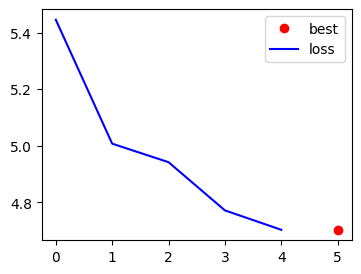

Best epoch so far:  5
Time  19.699 sec

Epoch 6 Batch 37 Loss: 4.7050
Epoch 6 Batch 74 Loss: 4.5401
Epoch 6 Batch 111 Loss: 4.5211
Epoch 6 Batch 148 Loss: 4.4834
Epoch 6 Batch 185 Loss: 4.5441
Epoch 6 Batch 222 Loss: 4.6408

*** Epoch 6 Loss 4.5998 ***

####################
Greedy| Q: Hello   A: i am 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am 
Beam  5 |  How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am do not 
Beam  5 |  What is your favorite restaurant ?  A: what 
%
Greedy| Q: Do you want to go out ?  A: i am 
Beam  5 |  Do you want to go out ?  A: you 
####################
checkpoint saved!
Best epoch so far:  6
Time  19.479 sec

Epoch 7 Batch 37 Loss: 4.6642
Epoch 7 Batch 74 Loss: 4.5387
Epoch 7 Batch 111 Loss: 4.4492
Epoch 7 Batch 148 Loss: 4.4422
Epoch 7 Batch 185 Loss: 4.6893
Epoch 7 Batch 222 Loss: 4.4171

*** Epoch 7 Loss 4.5536 ***

######

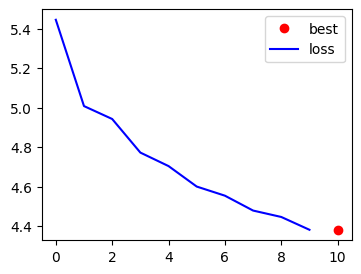

Best epoch so far:  10
Time  19.320 sec

Epoch 11 Batch 37 Loss: 4.4347
Epoch 11 Batch 74 Loss: 4.3082
Epoch 11 Batch 111 Loss: 4.2253
Epoch 11 Batch 148 Loss: 4.2798
Epoch 11 Batch 185 Loss: 4.4910
Epoch 11 Batch 222 Loss: 4.2501

*** Epoch 11 Loss 4.3568 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am sorry 
Beam  5 |  How are you ?  A: i i 
%
Greedy| Q: What are you doing ?  A: i do not know 
Beam  5 |  What are you doing ?  A: i i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: i you 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
Beam  5 |  Do you want to go out ?  A: no 
####################
checkpoint saved!
Best epoch so far:  11
Time  19.277 sec

Epoch 12 Batch 37 Loss: 4.3669
Epoch 12 Batch 74 Loss: 4.2735
Epoch 12 Batch 111 Loss: 4.2296
Epoch 12 Batch 148 Loss: 4.2980
Epoch 12 Batch 185 Loss: 4.2377
Epoch 12 Batch 222 Loss: 4.3947

*

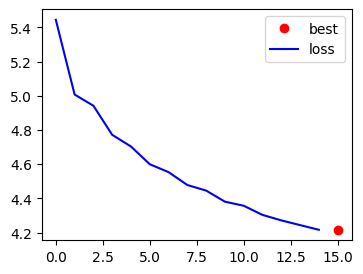

Best epoch so far:  15
Time  19.473 sec

Epoch 16 Batch 37 Loss: 4.2636
Epoch 16 Batch 74 Loss: 4.1440
Epoch 16 Batch 111 Loss: 4.1419
Epoch 16 Batch 148 Loss: 4.1604
Epoch 16 Batch 185 Loss: 4.0908
Epoch 16 Batch 222 Loss: 4.2650

*** Epoch 16 Loss 4.1936 ***

####################
Greedy| Q: Hello   A: i am sorry 
Beam  5 |  Hello   A: i you 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: i is 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
checkpoint saved!
Best epoch so far:  16
Time  19.283 sec

Epoch 17 Batch 37 Loss: 4.2933
Epoch 17 Batch 74 Loss: 4.1244
Epoch 17 Batch 111 Loss: 4.0866
Epoch 17 Batch 148 Loss: 4.1010
Epoch 17 Batch 185 Loss: 4.3210
Epoch 17 Batch 222 Loss: 4.1361

*** Ep

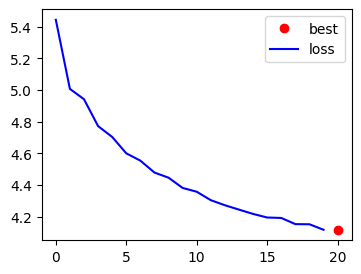

Best epoch so far:  20
Time  19.413 sec

Epoch 21 Batch 37 Loss: 4.1935
Epoch 21 Batch 74 Loss: 4.0298
Epoch 21 Batch 111 Loss: 4.0534
Epoch 21 Batch 148 Loss: 4.0696
Epoch 21 Batch 185 Loss: 4.2388
Epoch 21 Batch 222 Loss: 4.1254

*** Epoch 21 Loss 4.1158 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: no 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: i 
%
Greedy| Q: What are you doing ?  A: i am going to be 
Beam  5 |  What are you doing ?  A: i you 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i is 
####################
checkpoint saved!
Best epoch so far:  21
Time  19.469 sec

Epoch 22 Batch 37 Loss: 4.1675
Epoch 22 Batch 74 Loss: 4.0504
Epoch 22 Batch 111 Loss: 4.0260
Epoch 22 Batch 148 Loss: 4.0271
Epoch 22 Batch 185 Loss: 3.9427
Epoch 22 Batch 222 Loss: 4.0952

*** 

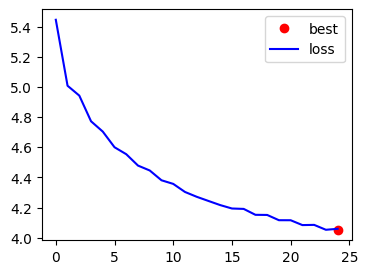

Best epoch so far:  24
Time  19.700 sec

Epoch 26 Batch 37 Loss: 4.1201
Epoch 26 Batch 74 Loss: 4.0000
Epoch 26 Batch 111 Loss: 3.9889
Epoch 26 Batch 148 Loss: 3.9586
Epoch 26 Batch 185 Loss: 3.9368
Epoch 26 Batch 222 Loss: 4.0261

*** Epoch 26 Loss 4.0281 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i will not be 
Beam  5 |  How are you ?  A: i is 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: no 
####################
checkpoint saved!
Best epoch so far:  26
Time  19.226 sec

Epoch 27 Batch 37 Loss: 4.1863
Epoch 27 Batch 74 Loss: 3.9637
Epoch 27 Batch 111 Loss: 3.9573
Epoch 27 Batch 148 Loss: 4.0010
Epoch 27 Batch 185 Loss: 4.1445
Epoch 27 Batch 222 Loss: 4.0922

*** Ep

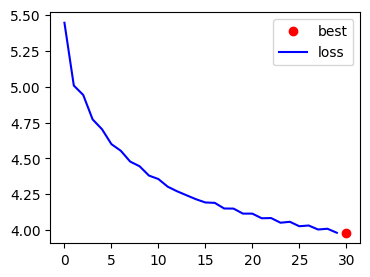

Best epoch so far:  30
Time  19.390 sec

Epoch 31 Batch 37 Loss: 4.1165
Epoch 31 Batch 74 Loss: 3.9003
Epoch 31 Batch 111 Loss: 3.9192
Epoch 31 Batch 148 Loss: 3.9456
Epoch 31 Batch 185 Loss: 4.0847
Epoch 31 Batch 222 Loss: 4.0377

*** Epoch 31 Loss 3.9916 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not going to be 
Beam  5 |  How are you ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: no 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: what 
####################
Best epoch so far:  30
Time  19.600 sec

Epoch 32 Batch 37 Loss: 4.0837
Epoch 32 Batch 74 Loss: 4.0571
Epoch 32 Batch 111 Loss: 3.8930
Epoch 32 Batch 148 Loss: 3.8100
Epoch 32 Batch 185 Loss: 3.9095
Epoch 32 Batch 222 Loss: 3.9434

*** Epoch 32 Loss

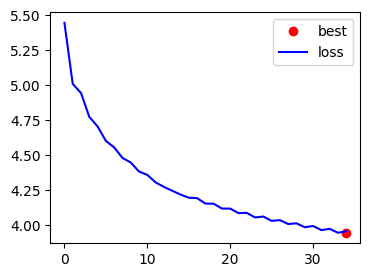

Best epoch so far:  34
Time  19.453 sec

Epoch 36 Batch 37 Loss: 4.0753
Epoch 36 Batch 74 Loss: 4.0245
Epoch 36 Batch 111 Loss: 3.8810
Epoch 36 Batch 148 Loss: 3.7643
Epoch 36 Batch 185 Loss: 3.8557
Epoch 36 Batch 222 Loss: 3.8731

*** Epoch 36 Loss 3.9276 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: that 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not a good 
Beam  5 |  What are you doing ?  A: no 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: what 
####################
checkpoint saved!
Best epoch so far:  36
Time  19.240 sec

Epoch 37 Batch 37 Loss: 4.0452
Epoch 37 Batch 74 Loss: 3.8228
Epoch 37 Batch 111 Loss: 3.8345
Epoch 37 Batch 148 Loss: 3.8262
Epoch 37 Batch 185 Loss: 3.9528
Epoch 37 Batch 222 Loss: 3.

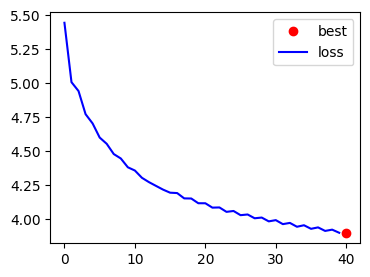

Best epoch so far:  40
Time  19.447 sec

Epoch 41 Batch 37 Loss: 4.0102
Epoch 41 Batch 74 Loss: 3.8065
Epoch 41 Batch 111 Loss: 3.8074
Epoch 41 Batch 148 Loss: 3.8038
Epoch 41 Batch 185 Loss: 3.9283
Epoch 41 Batch 222 Loss: 3.9911

*** Epoch 41 Loss 3.9086 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: that 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: we 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: that 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry you 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i i 
####################
Best epoch so far:  40
Time  19.340 sec

Epoch 42 Batch 37 Loss: 4.0202
Epoch 42 Batch 74 Loss: 4.0621
Epoch 42 Batch 111 Loss: 3.8752
Epoch 42 Batch 148 Loss: 3.6653
Epoch 42 Batch 185 Loss: 3.8169
Epoch 42 Batch 222 Loss: 3.8363

*** Epoch 42 Loss

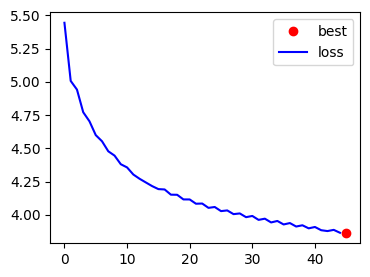

Best epoch so far:  45
Time  19.354 sec

Epoch 46 Batch 37 Loss: 3.9757
Epoch 46 Batch 74 Loss: 3.8695
Epoch 46 Batch 111 Loss: 3.7696
Epoch 46 Batch 148 Loss: 3.7755
Epoch 46 Batch 185 Loss: 4.0866
Epoch 46 Batch 222 Loss: 3.8345

*** Epoch 46 Loss 3.8754 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: the 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
Beam  5 |  Do you want to go out ?  A: it 
####################
Best epoch so far:  45
Time  19.315 sec

Epoch 47 Batch 37 Loss: 3.9954
Epoch 47 Batch 74 Loss: 3.7900
Epoch 47 Batch 111 Loss: 3.7677
Epoch 47 Batch 148 Loss: 3.7116
Epoch 47 Batch 185 Loss: 3.8747
Epoch 47 Batch 222 Loss: 3.9804

*** Epoch 47 Loss 3.8534 ***

##

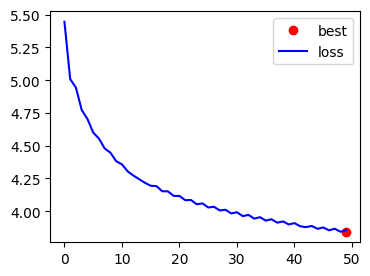

Best epoch so far:  49
Time  19.428 sec

Epoch 51 Batch 37 Loss: 3.9205
Epoch 51 Batch 74 Loss: 3.7705
Epoch 51 Batch 111 Loss: 3.7642
Epoch 51 Batch 148 Loss: 3.7327
Epoch 51 Batch 185 Loss: 3.8066
Epoch 51 Batch 222 Loss: 3.9690

*** Epoch 51 Loss 3.8335 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i do not know 
Beam  5 |  How are you ?  A: the 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: we 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
Beam  5 |  Do you want to go out ?  A: i 
####################
checkpoint saved!
Best epoch so far:  51
Time  19.277 sec

Epoch 52 Batch 37 Loss: 3.9350
Epoch 52 Batch 74 Loss: 3.7614
Epoch 52 Batch 111 Loss: 3.7608
Epoch 52 Batch 148 Loss: 3.7466
Epoch 52 Batch 185 Loss: 4.0471
Epoch 52 Batch 222 Loss: 3.8326

*** 

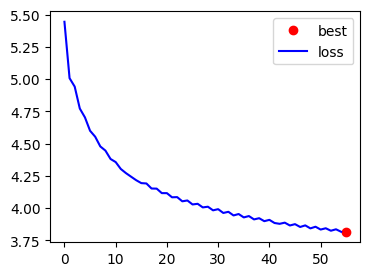

Best epoch so far:  55
Time  19.658 sec

Epoch 56 Batch 37 Loss: 3.9162
Epoch 56 Batch 74 Loss: 4.0831
Epoch 56 Batch 111 Loss: 3.8186
Epoch 56 Batch 148 Loss: 3.6402
Epoch 56 Batch 185 Loss: 3.8132
Epoch 56 Batch 222 Loss: 3.8010

*** Epoch 56 Loss 3.8102 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not a good time 
Beam  5 |  What are you doing ?  A: the 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: what 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
Beam  5 |  Do you want to go out ?  A: i i 
####################
checkpoint saved!
Best epoch so far:  56
Time  19.312 sec

Epoch 57 Batch 37 Loss: 3.8960
Epoch 57 Batch 74 Loss: 3.7748
Epoch 57 Batch 111 Loss: 3.7487
Epoch 57 Batch 148 Loss: 3.7128
Epoch 57 Batch 185 Loss: 3.7414
Epoch 57 Batch 222 L

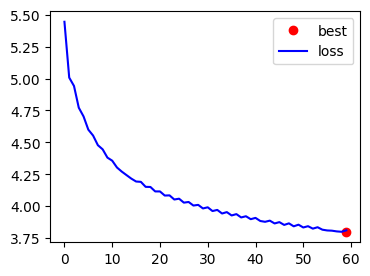

Best epoch so far:  59
Time  19.401 sec

Epoch 61 Batch 37 Loss: 3.8734
Epoch 61 Batch 74 Loss: 3.7571
Epoch 61 Batch 111 Loss: 3.7708
Epoch 61 Batch 148 Loss: 3.7108
Epoch 61 Batch 185 Loss: 3.6742
Epoch 61 Batch 222 Loss: 3.8434

*** Epoch 61 Loss 3.7931 ***

####################
Greedy| Q: Hello   A: hi 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not going to do 
Beam  5 |  How are you ?  A: we 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: i i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
checkpoint saved!
Best epoch so far:  61
Time  19.516 sec

Epoch 62 Batch 37 Loss: 3.8794
Epoch 62 Batch 74 Loss: 3.7008
Epoch 62 Batch 111 Loss: 3.7474
Epoch 62 Batch 148 Loss: 3.7240
Epoch 62 Batch 185 Loss: 3.9298
Epoch 62 Batch 222 Loss: 3.

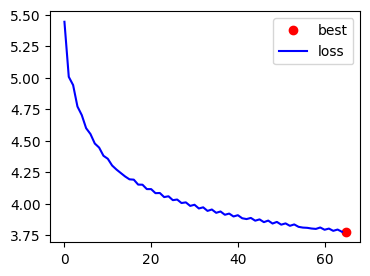

Best epoch so far:  65
Time  19.358 sec

Epoch 66 Batch 37 Loss: 3.8913
Epoch 66 Batch 74 Loss: 3.7214
Epoch 66 Batch 111 Loss: 3.7221
Epoch 66 Batch 148 Loss: 3.7179
Epoch 66 Batch 185 Loss: 3.9040
Epoch 66 Batch 222 Loss: 3.8673

*** Epoch 66 Loss 3.7902 ***

####################
Greedy| Q: Hello   A: you are not going to be 
Beam  5 |  Hello   A: no 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: the 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: the 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
Best epoch so far:  65
Time  19.402 sec

Epoch 67 Batch 37 Loss: 3.8630
Epoch 67 Batch 74 Loss: 3.7579
Epoch 67 Batch 111 Loss: 3.7360
Epoch 67 Batch 148 Loss: 3.6711
Epoch 67 Batch 185 Loss: 3.6764
Epoch 67 Batch 222 Loss: 3.8043

*** Epoch 67 Lo

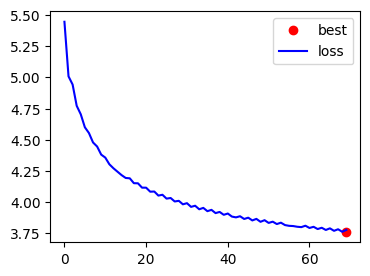

Best epoch so far:  69
Time  19.394 sec

Epoch 71 Batch 37 Loss: 3.8833
Epoch 71 Batch 74 Loss: 3.7715
Epoch 71 Batch 111 Loss: 3.7141
Epoch 71 Batch 148 Loss: 3.6636
Epoch 71 Batch 185 Loss: 3.6682
Epoch 71 Batch 222 Loss: 3.7994

*** Epoch 71 Loss 3.7563 ***

####################
Greedy| Q: Hello   A: i do not know 
Beam  5 |  Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: the 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
Beam  5 |  Do you want to go out ?  A: what 
####################
checkpoint saved!
Best epoch so far:  71
Time  19.304 sec

Epoch 72 Batch 37 Loss: 3.9141
Epoch 72 Batch 74 Loss: 3.6812
Epoch 72 Batch 111 Loss: 3.7060
Epoch 72 Batch 148 Loss: 3.6978
Epoch 72 Batch 185 Loss: 3.8463
Epoch 72 Batch 222 

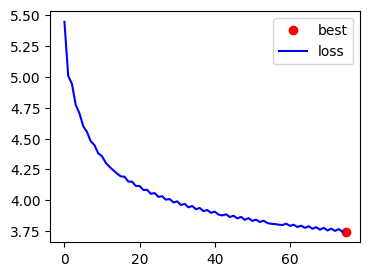

Best epoch so far:  75
Time  19.412 sec

Epoch 76 Batch 37 Loss: 3.8686
Epoch 76 Batch 74 Loss: 3.6518
Epoch 76 Batch 111 Loss: 3.6868
Epoch 76 Batch 148 Loss: 3.6974
Epoch 76 Batch 185 Loss: 3.8277
Epoch 76 Batch 222 Loss: 3.8277

*** Epoch 76 Loss 3.7592 ***

####################
Greedy| Q: Hello   A: i am not you 
Beam  5 |  Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be 
Beam  5 |  How are you ?  A: the 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: the 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
Best epoch so far:  75
Time  19.420 sec

Epoch 77 Batch 37 Loss: 3.8595
Epoch 77 Batch 74 Loss: 3.8054
Epoch 77 Batch 111 Loss: 3.6516
Epoch 77 Batch 148 Loss: 3.5347
Epoch 77 Batch 185 Loss: 3.6681
Epoch 77 Batch 222 Loss: 3.7564

*** Epoch 77 Lo

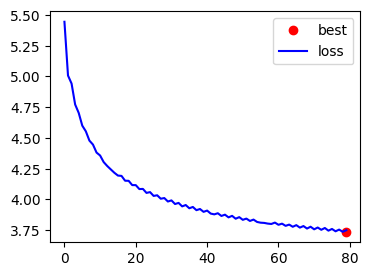

Best epoch so far:  79
Time  19.679 sec

Epoch 81 Batch 37 Loss: 3.8638
Epoch 81 Batch 74 Loss: 3.8408
Epoch 81 Batch 111 Loss: 3.7270
Epoch 81 Batch 148 Loss: 3.5323
Epoch 81 Batch 185 Loss: 3.6629
Epoch 81 Batch 222 Loss: 3.7172

*** Epoch 81 Loss 3.7295 ***

####################
Greedy| Q: Hello   A: i am sorry 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am not going to be 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
Beam  5 |  What are you doing ?  A: the 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not a good idea 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
checkpoint saved!
Best epoch so far:  81
Time  19.280 sec

Epoch 82 Batch 37 Loss: 3.8745
Epoch 82 Batch 74 Loss: 3.6294
Epoch 82 Batch 111 Loss: 3.6675
Epoch 82 Batch 148 Loss: 3.6286
Epoch 82 Batch 185 Loss: 3.7529
Epoch 

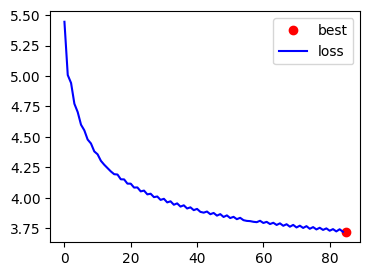

Best epoch so far:  85
Time  19.341 sec

Epoch 86 Batch 37 Loss: 3.8659
Epoch 86 Batch 74 Loss: 3.6632
Epoch 86 Batch 111 Loss: 3.6685
Epoch 86 Batch 148 Loss: 3.5778
Epoch 86 Batch 185 Loss: 3.7315
Epoch 86 Batch 222 Loss: 3.8516

*** Epoch 86 Loss 3.7219 ***

####################
Greedy| Q: Hello   A: i am sorry 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i do not know 
Beam  5 |  How are you ?  A: that 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: we 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
Beam  5 |  Do you want to go out ?  A: yes 
####################
Best epoch so far:  85
Time  19.542 sec

Epoch 87 Batch 37 Loss: 3.8501
Epoch 87 Batch 74 Loss: 3.7040
Epoch 87 Batch 111 Loss: 3.6066
Epoch 87 Batch 148 Loss: 3.6247
Epoch 87 Batch 185 Loss: 3.9620
Epoch 87 Batch 222 Loss: 3.6815

***

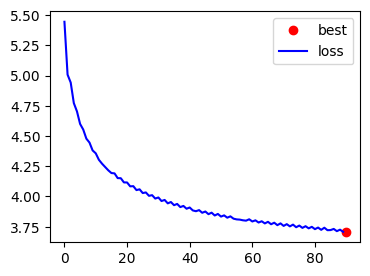

Best epoch so far:  90
Time  19.342 sec

Epoch 91 Batch 37 Loss: 3.8368
Epoch 91 Batch 74 Loss: 3.6515
Epoch 91 Batch 111 Loss: 3.6230
Epoch 91 Batch 148 Loss: 3.6165
Epoch 91 Batch 185 Loss: 3.9144
Epoch 91 Batch 222 Loss: 3.6818

*** Epoch 91 Loss 3.7226 ***

####################
Greedy| Q: Hello   A: hi 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am not going to do 
Beam  5 |  How are you ?  A: i i 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
Beam  5 |  Do you want to go out ?  A: i i 
####################
Best epoch so far:  90
Time  19.386 sec

Epoch 92 Batch 37 Loss: 3.8181
Epoch 92 Batch 74 Loss: 3.6661
Epoch 92 Batch 111 Loss: 3.6179
Epoch 92 Batch 148 Loss: 3.5325
Epoch 92 Batch 185 Loss: 3.6822
Epoch 92 Batch 222 Loss: 3.8182

*** Epoch 92 Los

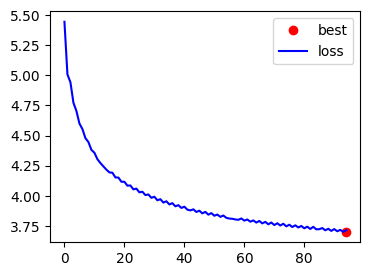

Best epoch so far:  94
Time  19.432 sec

Epoch 96 Batch 37 Loss: 3.7711
Epoch 96 Batch 74 Loss: 3.6805
Epoch 96 Batch 111 Loss: 3.6469
Epoch 96 Batch 148 Loss: 3.6171
Epoch 96 Batch 185 Loss: 3.6574
Epoch 96 Batch 222 Loss: 3.8331

*** Epoch 96 Loss 3.6967 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am sorry 
Beam  5 |  How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not it 
Beam  5 |  What is your favorite restaurant ?  A: the 
%
Greedy| Q: Do you want to go out ?  A: i am not going to be 
Beam  5 |  Do you want to go out ?  A: i 
####################
checkpoint saved!
Best epoch so far:  96
Time  19.281 sec

Epoch 97 Batch 37 Loss: 3.8045
Epoch 97 Batch 74 Loss: 3.5951
Epoch 97 Batch 111 Loss: 3.6280
Epoch 97 Batch 148 Loss: 3.5963
Epoch 97 Batch 185 Loss: 3.8849
Epoch 97 Batch 222 Loss: 3.71

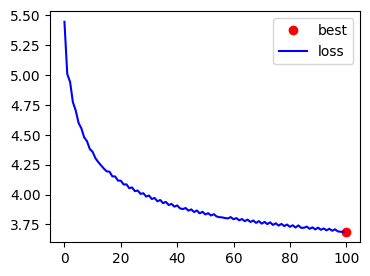

Best epoch so far:  100
Time  19.443 sec



In [25]:
import math
X, y = [], []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS+1):
    current_ep = ep
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:

        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q)[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a)[0]

        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :

            batch_loss = train_step(
                torch.Tensor(X).to(torch.int32),
                torch.Tensor(y).to(torch.long),
                enc_hidden,
                device
                )
            if not math.isnan(batch_loss):
              total_loss += batch_loss
              btch += 1
            X , y = [], []
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, batch_loss))
    epoch_loss =  total_loss / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)


    test_bot(beam=True)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep

        torch.save(encoder, f'encoder_{ep}.pth')
        torch.save(decoder, f'decoder_{ep}.pth')

        print('checkpoint saved!')

    if ep % 5 == 0:
        plot_history()

    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [28]:
# encoder = torch.load(f'encoder_{best_ep}.pth')
# decoder = torch.load(f'decoder_{best_ep}.pth')
encoder = torch.load(f'encoder_{best_ep}.pth', weights_only=False)
decoder = torch.load(f'decoder_{best_ep}.pth', weights_only=False)

print('load best checkpoint from ep:', best_ep)
test_bot(k=5,beam=True)


load best checkpoint from ep: 100
####################
Greedy| Q: Hello   A: i am not you 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i do not know 
Beam  5 |  What are you doing ?  A: the 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: what 
####################


Input: how old are you
Predicted answer: i am not 


<ipython-input-19-fb9f6a0e0510>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-19-fb9f6a0e0510>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


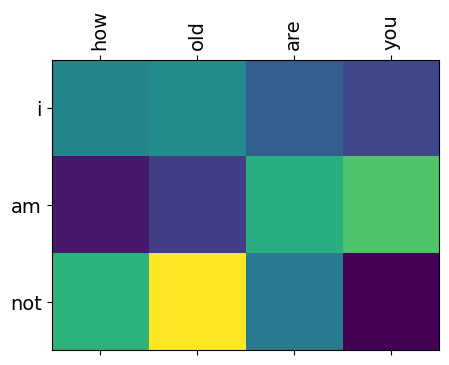

In [29]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: i am not you 


<ipython-input-19-fb9f6a0e0510>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-19-fb9f6a0e0510>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


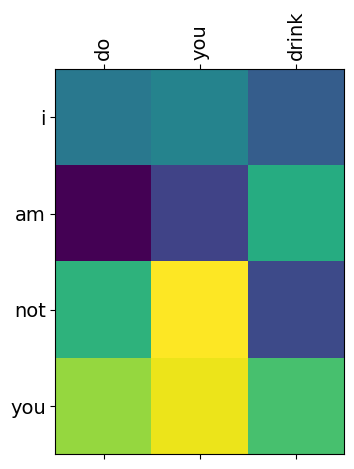

In [30]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 100 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?

Loaded model from epoch: 5

Predictions at Epoch 5:
Input: Hello
Input: hello
Predicted answer: hi 


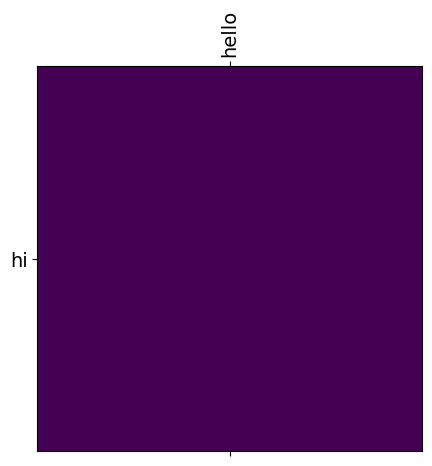

--------------------
Input: How are you?
Error loading model from epoch 5: 'you?'
No checkpoint found for epoch 50. Skipping.
Loaded model from epoch: 100

Predictions at Epoch 100:
Input: Hello
Input: hello
Predicted answer: i am sorry 


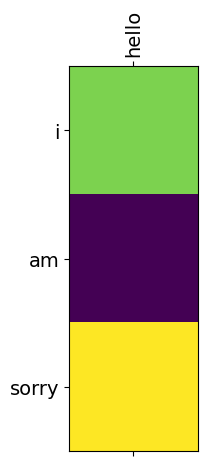

--------------------
Input: How are you?
Error loading model from epoch 100: 'you?'


In [32]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_queries = [
    "Hello",
    "How are you?",
    "What are you doing?",
    "What is your favorite restaurant?",
    "Do you want to go out?",
    "How old are you?",
    "Do you drink?",
    "What time is it?",
    "Can you help me?",
    "Where are you from?"
]

def load_and_test_model(epoch):
    try:
        encoder = torch.load(f'encoder_{epoch}.pth', weights_only=False)
        decoder = torch.load(f'decoder_{epoch}.pth', weights_only=False)

        print(f"Loaded model from epoch: {epoch}")

        print(f"\nPredictions at Epoch {epoch}:")
        print("======================")
        for query in sample_queries:
            print(f"Input: {query}")
            answer(query, training=False)
            print("--------------------")
        print("======================")

    except FileNotFoundError:
        print(f"No checkpoint found for epoch {epoch}. Skipping.")
    except Exception as e:
        print(f"Error loading model from epoch {epoch}: {str(e)}")

epochs_to_compare = [5, 50, 100]

for epoch in epochs_to_compare:
    load_and_test_model(epoch)

plt.show()